In [8]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms


In [9]:
def show(tensor, ch=1, size=(28, 28), num = 16):
    data = tensor.detach().cpu().view(-1, ch, *size)
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0)
    plt.imshow(grid)
    plt.show()

In [20]:
epochs = 300
cur_step = 0
info_step = 2000
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), batch_size=bs, shuffle=True)

In [11]:
def genBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim),
            genBlock(h_dim, h_dim*2),
            genBlock(h_dim*2, h_dim*4),
            genBlock(h_dim*4, h_dim*8),
            nn.Linear(h_dim*8, i_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)

def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device) 

In [12]:
def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.LeakyReLU(0.2, inplace=True)
    )

class Discriminator(nn.Module):
    def __init__(self, i_dim=784, h_dim=256):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discBlock(i_dim, h_dim*4),
            discBlock(h_dim*4, h_dim*2),
            discBlock(h_dim*2, h_dim),
            nn.Linear(h_dim, 1)
        )
    def forward(self, image):
        return self.disc(image)

In [13]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [14]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [15]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [16]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([9, 7, 0, 2, 8, 3, 3, 1, 7, 7])


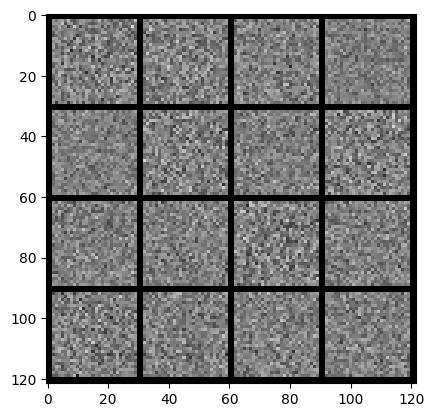

In [17]:
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [18]:
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    gen_loss = loss_func(pred, torch.ones_like(pred))
    return gen_loss

def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    disc_fake = disc(fake.detach())
    disc_fake_loss = loss_func(disc_fake, torch.zeros_like(disc_fake))

    disc_real = disc(real)
    disc_real_loss = loss_func(disc_real, torch.ones_like(disc_real))

    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss


 26%|██▋       | 124/469 [00:01<00:03, 96.15it/s]

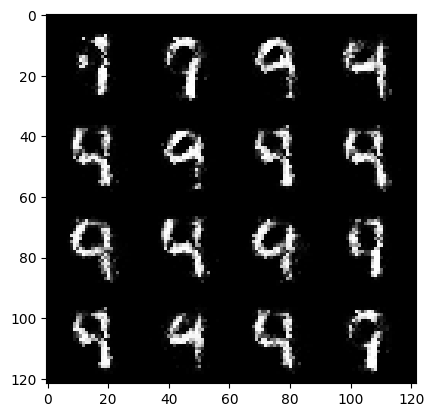

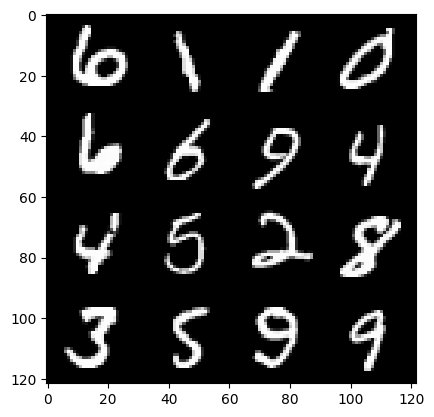

 31%|███       | 144/469 [00:01<00:04, 80.32it/s]

Epoch 4, Step 2000: Gen Loss 5.977246848106406, Disc Loss 0.03507932910392997


 51%|█████     | 240/469 [00:02<00:02, 98.05it/s]

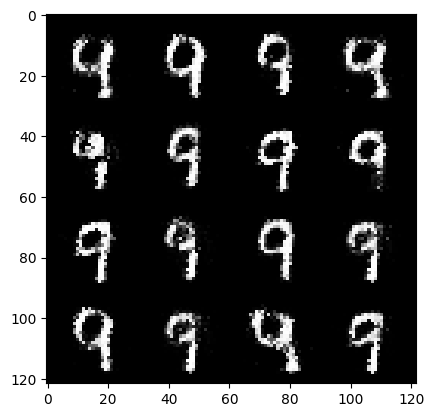

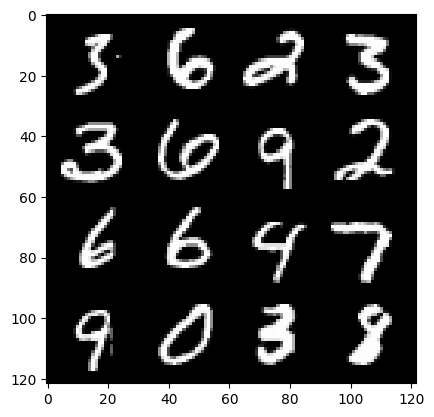

 55%|█████▌    | 260/469 [00:02<00:02, 70.64it/s]

Epoch 8, Step 4000: Gen Loss 5.314414626479139, Disc Loss 0.0413736102906986


 77%|███████▋  | 363/469 [00:03<00:01, 98.26it/s]

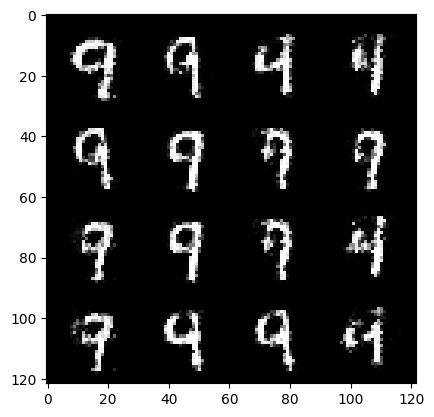

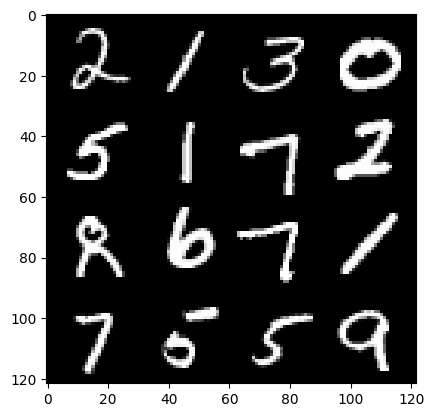

 81%|████████▏ | 382/469 [00:04<00:01, 74.44it/s]

Epoch 12, Step 6000: Gen Loss 4.959242322921756, Disc Loss 0.05239871447137545


  4%|▍         | 20/469 [00:00<00:04, 90.87it/s]

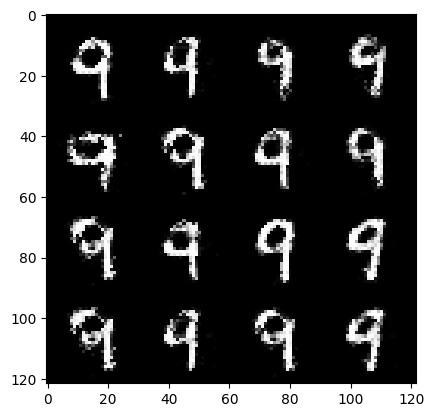

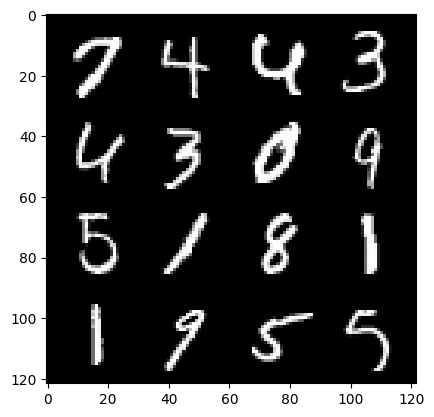

  8%|▊         | 39/469 [00:00<00:06, 70.54it/s]

Epoch 17, Step 8000: Gen Loss 4.863080099344269, Disc Loss 0.055709682788001404


 30%|███       | 142/469 [00:01<00:03, 98.65it/s]

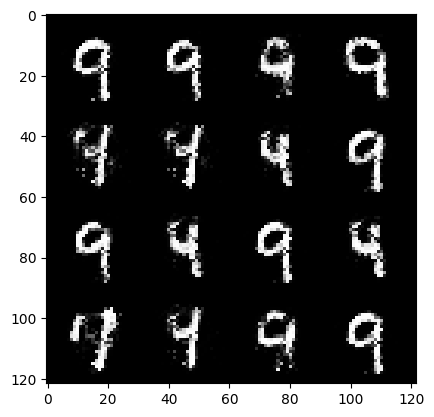

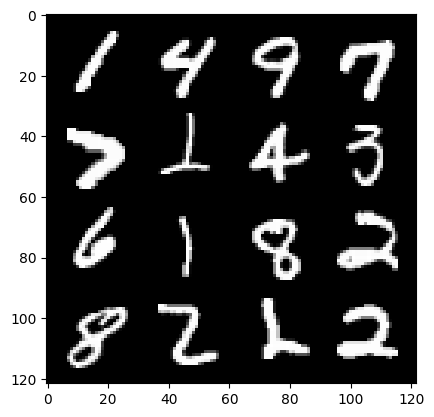

 35%|███▍      | 162/469 [00:01<00:03, 78.08it/s]

Epoch 21, Step 10000: Gen Loss 4.786774905443185, Disc Loss 0.05692240359960121


 57%|█████▋    | 268/469 [00:02<00:02, 96.18it/s]

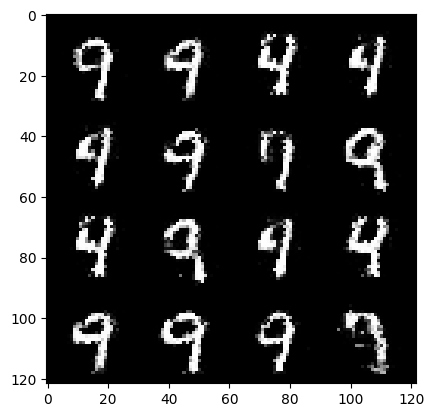

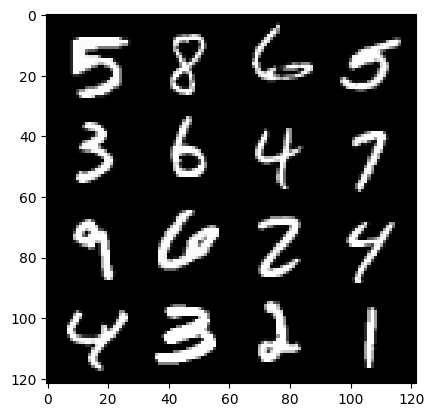

 61%|██████    | 287/469 [00:03<00:02, 75.87it/s]

Epoch 25, Step 12000: Gen Loss 4.727091092705728, Disc Loss 0.05806769001041544


 84%|████████▍ | 395/469 [00:04<00:00, 96.04it/s] 

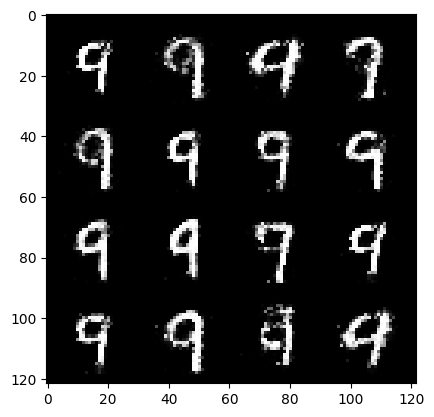

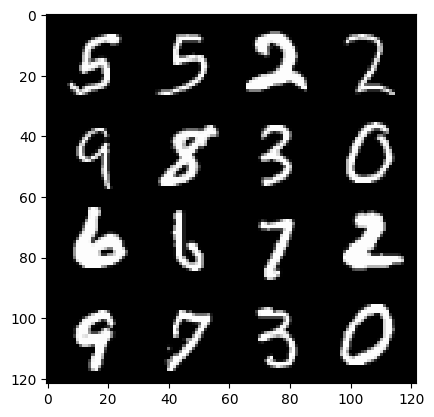

 88%|████████▊ | 415/469 [00:04<00:00, 79.96it/s]

Epoch 29, Step 14000: Gen Loss 4.48107111263275, Disc Loss 0.06783287146873775


 11%|█         | 50/469 [00:00<00:04, 89.71it/s]

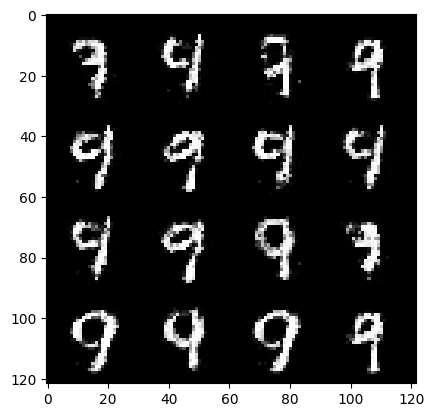

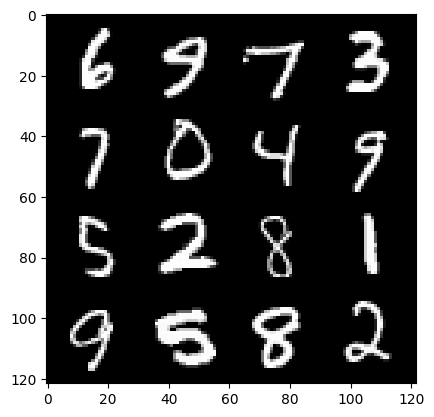

 14%|█▍        | 68/469 [00:00<00:05, 70.89it/s]

Epoch 34, Step 16000: Gen Loss 4.247626659154886, Disc Loss 0.08009746120031919


 36%|███▌      | 170/469 [00:01<00:03, 97.16it/s]

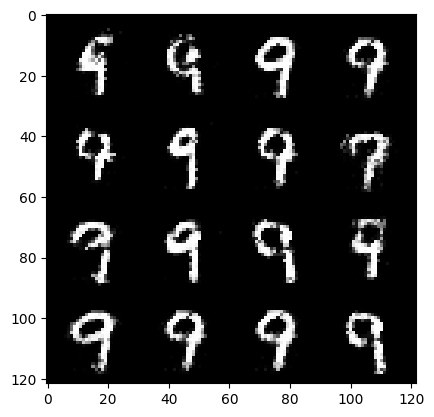

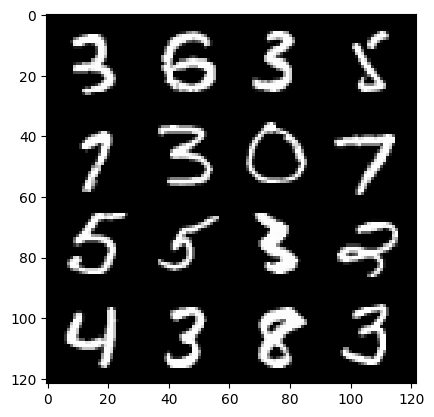

 41%|████      | 190/469 [00:02<00:03, 81.11it/s]

Epoch 38, Step 18000: Gen Loss 4.0030460206270195, Disc Loss 0.09145713136438277


 64%|██████▍   | 302/469 [00:03<00:01, 88.13it/s]

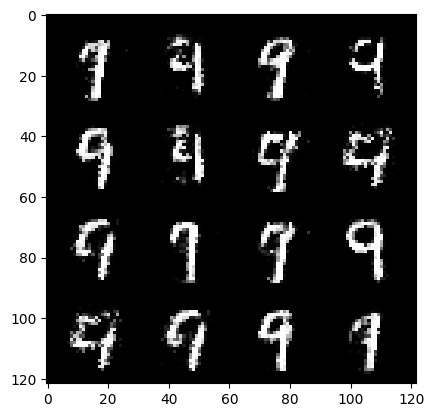

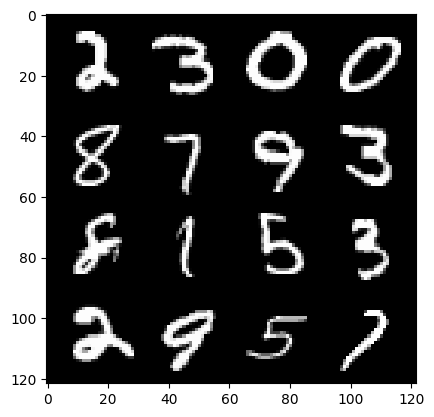

 66%|██████▋   | 311/469 [00:03<00:02, 67.04it/s]

Epoch 42, Step 20000: Gen Loss 3.930081470251073, Disc Loss 0.09188544658385221


 91%|█████████ | 425/469 [00:04<00:00, 83.86it/s]

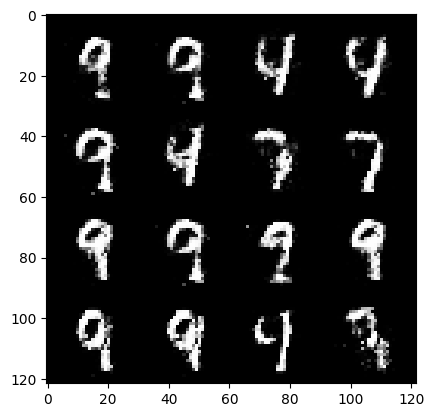

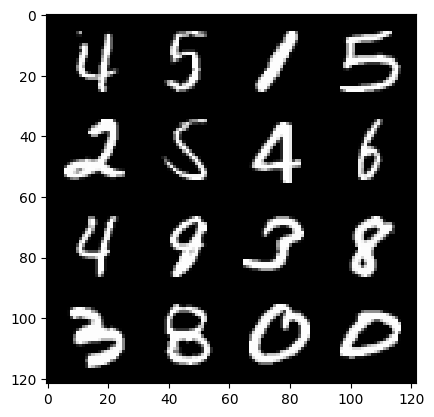

 94%|█████████▍| 443/469 [00:05<00:00, 69.31it/s]

Epoch 46, Step 22000: Gen Loss 3.7138152023553954, Disc Loss 0.1025198304532095


 16%|█▌        | 74/469 [00:00<00:04, 89.52it/s]

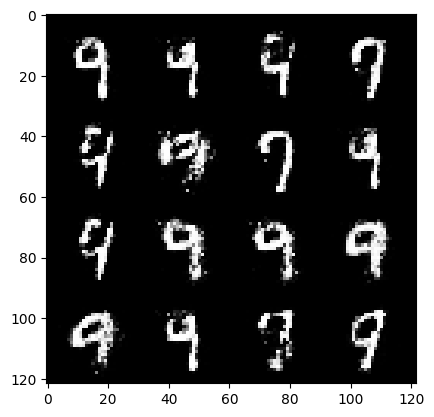

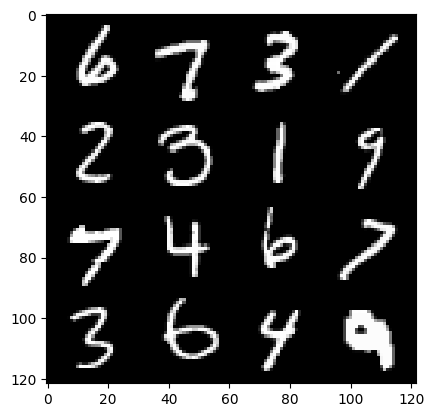

 19%|█▉        | 91/469 [00:01<00:05, 70.32it/s]

Epoch 51, Step 24000: Gen Loss 3.749374547839172, Disc Loss 0.10170366315124561


 43%|████▎     | 200/469 [00:02<00:02, 91.76it/s]

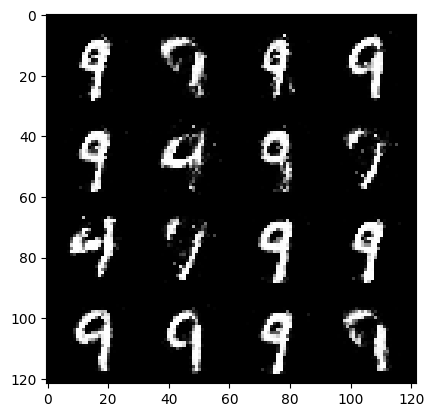

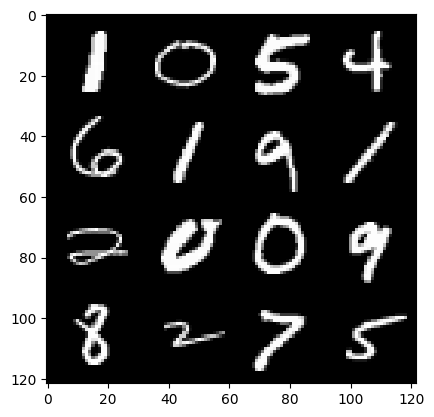

 47%|████▋     | 219/469 [00:02<00:03, 75.05it/s]

Epoch 55, Step 26000: Gen Loss 3.6761069370508173, Disc Loss 0.10301372577529407


 70%|██████▉   | 328/469 [00:03<00:01, 93.17it/s]

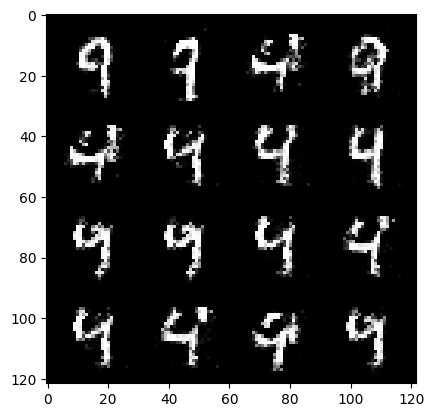

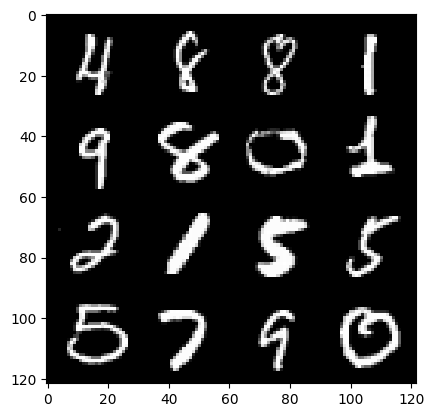

 74%|███████▍  | 348/469 [00:03<00:01, 76.49it/s]

Epoch 59, Step 28000: Gen Loss 3.5027297209501267, Disc Loss 0.11291797390393901


 96%|█████████▌| 448/469 [00:04<00:00, 91.79it/s]

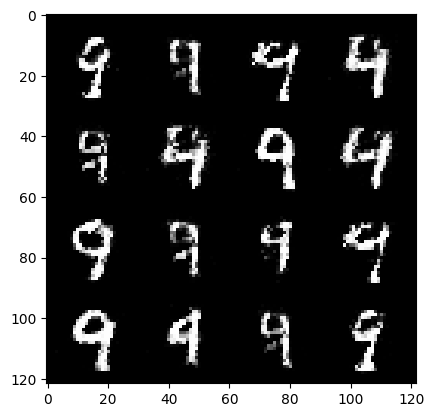

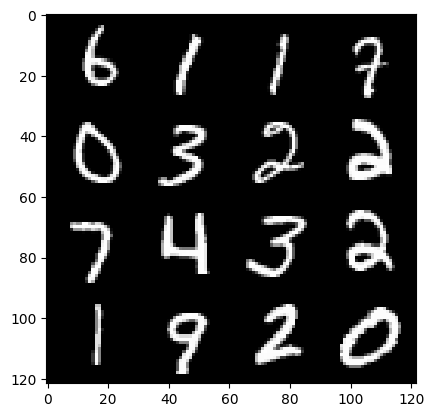

100%|██████████| 469/469 [00:05<00:00, 88.30it/s]


Epoch 63, Step 30000: Gen Loss 3.5017724709510785, Disc Loss 0.11133729219809171


 22%|██▏       | 101/469 [00:01<00:03, 97.67it/s]

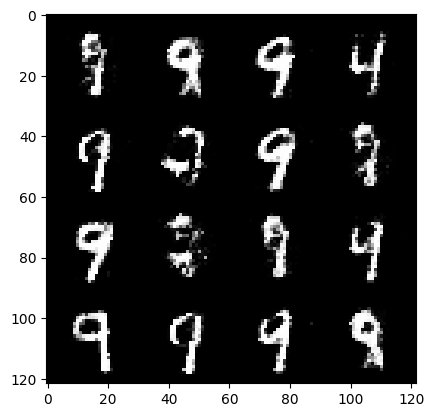

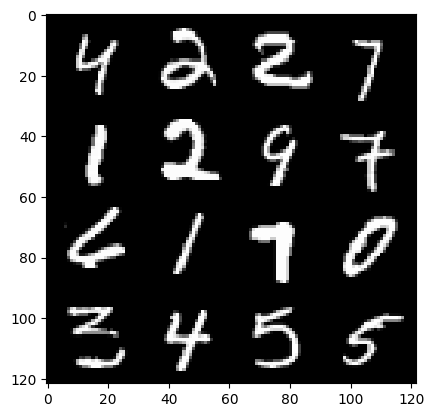

 26%|██▌       | 121/469 [00:01<00:04, 80.47it/s]

Epoch 68, Step 32000: Gen Loss 3.3215541646480564, Disc Loss 0.12552159139141433


 49%|████▉     | 231/469 [00:02<00:02, 102.92it/s]

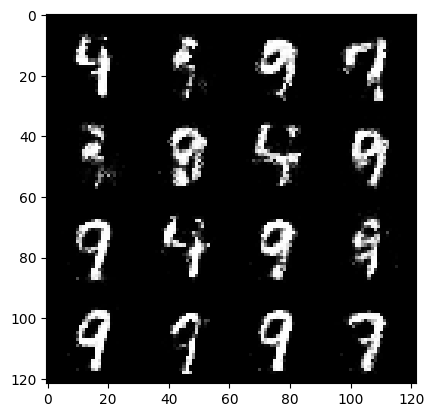

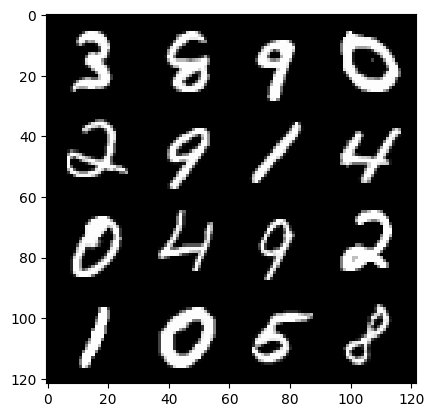

 54%|█████▎    | 252/469 [00:02<00:02, 83.63it/s] 

Epoch 72, Step 34000: Gen Loss 3.1398657308816875, Disc Loss 0.14726551876589633


 75%|███████▍  | 351/469 [00:03<00:01, 101.96it/s]

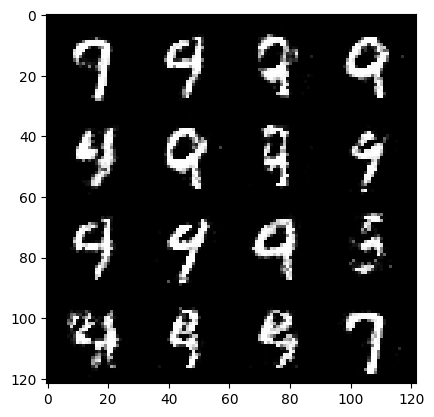

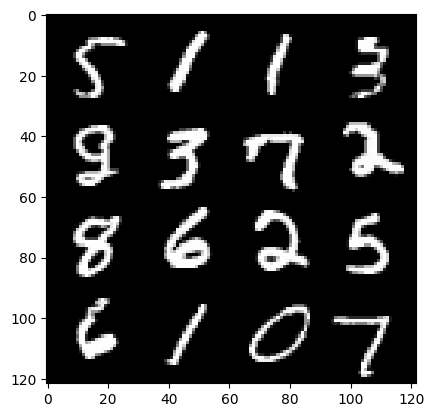

 79%|███████▉  | 372/469 [00:03<00:01, 82.64it/s] 

Epoch 76, Step 36000: Gen Loss 2.967132488965994, Disc Loss 0.16214057512208851


  2%|▏         | 11/469 [00:00<00:04, 100.30it/s]

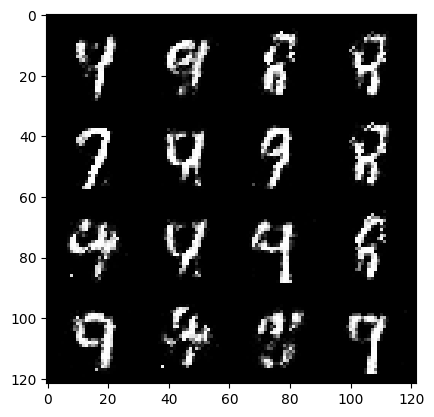

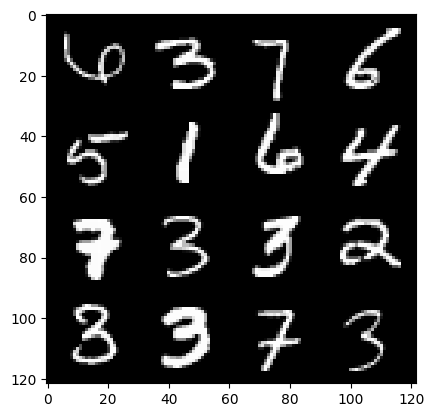

  5%|▍         | 22/469 [00:00<00:06, 65.51it/s] 

Epoch 81, Step 38000: Gen Loss 2.9590560448169687, Disc Loss 0.15991324935108447


 28%|██▊       | 130/469 [00:01<00:03, 96.10it/s]

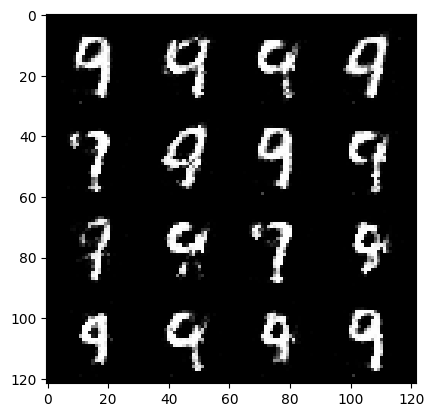

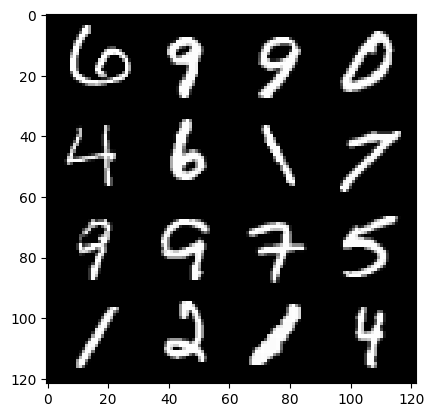

 32%|███▏      | 150/469 [00:01<00:04, 79.31it/s]

Epoch 85, Step 40000: Gen Loss 2.8442556092739095, Disc Loss 0.17068972843140362


 54%|█████▎    | 252/469 [00:02<00:02, 102.61it/s]

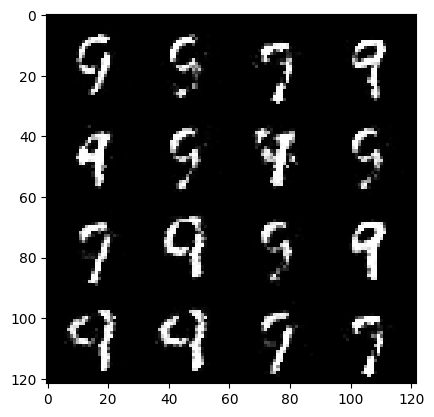

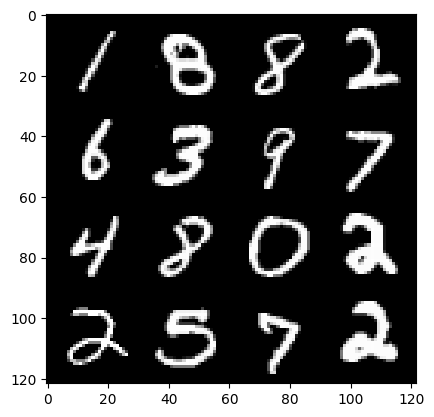

 58%|█████▊    | 272/469 [00:02<00:02, 80.91it/s] 

Epoch 89, Step 42000: Gen Loss 2.8851934448480603, Disc Loss 0.1584222665000705


 81%|████████▏ | 382/469 [00:03<00:00, 102.64it/s]

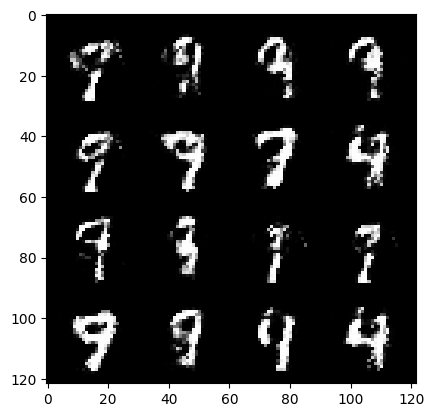

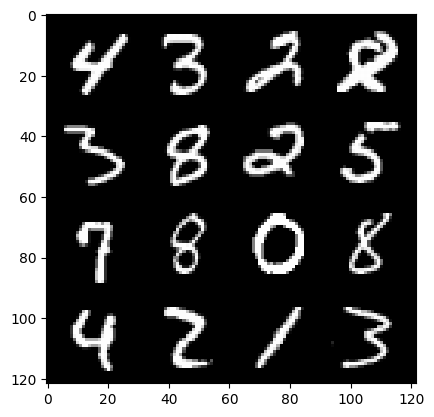

 84%|████████▍ | 393/469 [00:03<00:00, 78.39it/s] 

Epoch 93, Step 44000: Gen Loss 2.776047037839891, Disc Loss 0.1688579774796961


  7%|▋         | 33/469 [00:00<00:04, 101.64it/s]

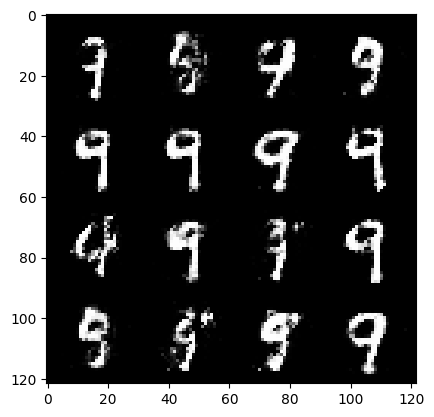

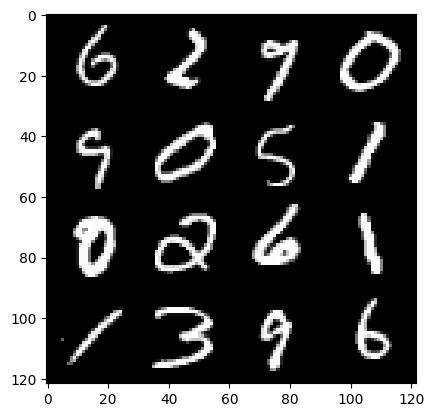

 12%|█▏        | 54/469 [00:00<00:05, 79.41it/s] 

Epoch 98, Step 46000: Gen Loss 2.7148897026777226, Disc Loss 0.17794126965850607


 33%|███▎      | 154/469 [00:01<00:03, 101.24it/s]

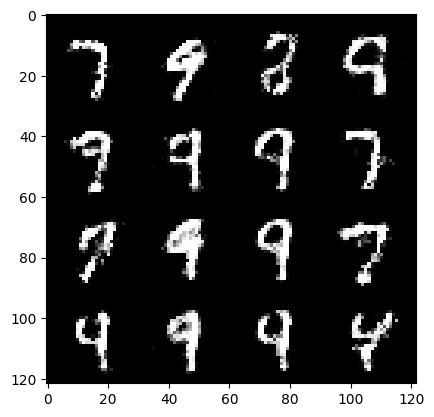

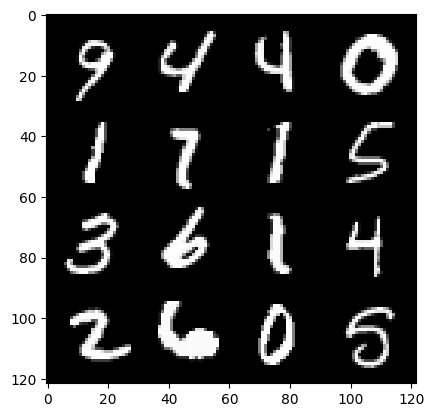

 37%|███▋      | 175/469 [00:01<00:03, 83.89it/s] 

Epoch 102, Step 48000: Gen Loss 2.677386912226678, Disc Loss 0.18519307115674002


 60%|██████    | 283/469 [00:02<00:01, 98.32it/s]

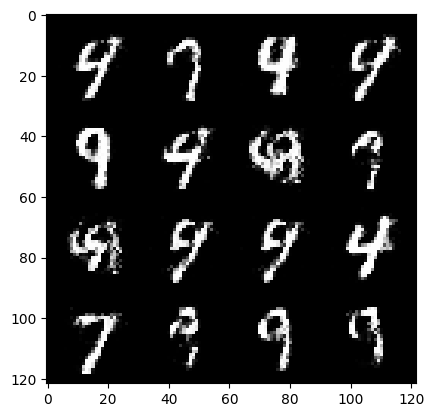

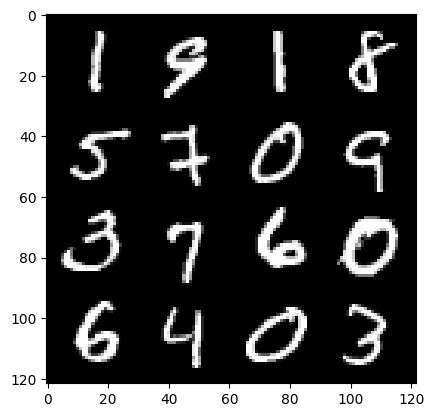

 65%|██████▍   | 303/469 [00:03<00:02, 79.27it/s]

Epoch 106, Step 50000: Gen Loss 2.542180363535882, Disc Loss 0.1984938179925087


 86%|████████▋ | 405/469 [00:04<00:00, 101.24it/s]

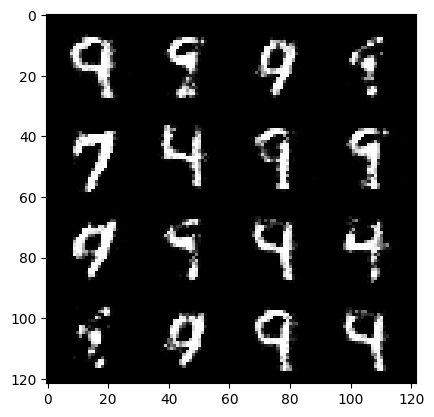

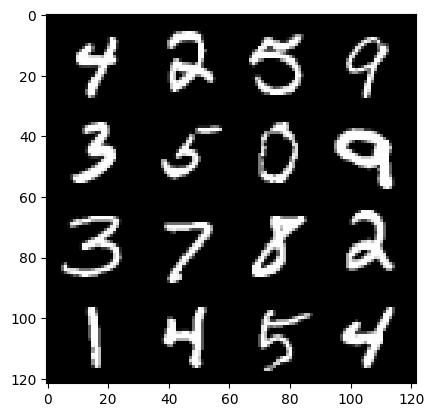

 91%|█████████ | 426/469 [00:04<00:00, 83.25it/s] 

Epoch 110, Step 52000: Gen Loss 2.5540097335577023, Disc Loss 0.19490286849066582


 14%|█▍        | 65/469 [00:00<00:03, 101.83it/s]

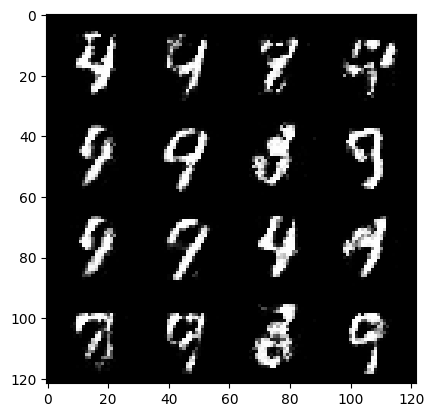

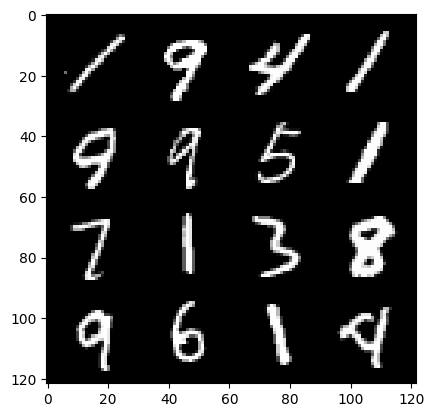

 16%|█▌        | 76/469 [00:00<00:06, 64.80it/s] 

Epoch 115, Step 54000: Gen Loss 2.534404677212239, Disc Loss 0.1987134962826966


 40%|███▉      | 187/469 [00:01<00:02, 101.92it/s]

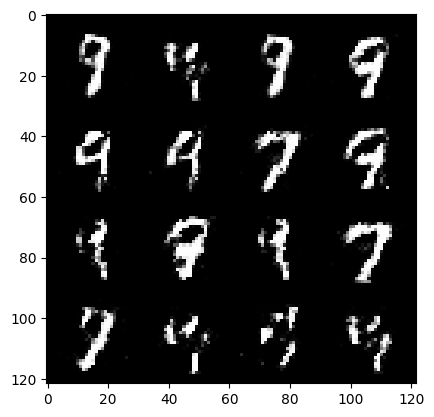

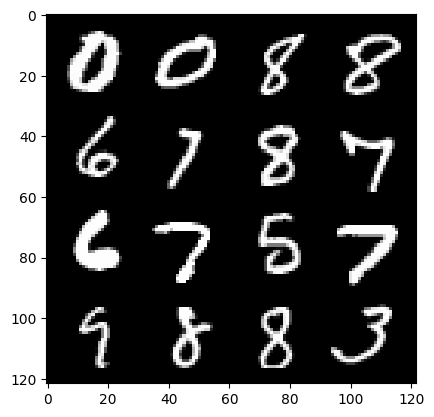

 44%|████▍     | 208/469 [00:02<00:03, 82.71it/s] 

Epoch 119, Step 56000: Gen Loss 2.4253860851526254, Disc Loss 0.2135828652828935


 67%|██████▋   | 313/469 [00:03<00:01, 98.25it/s] 

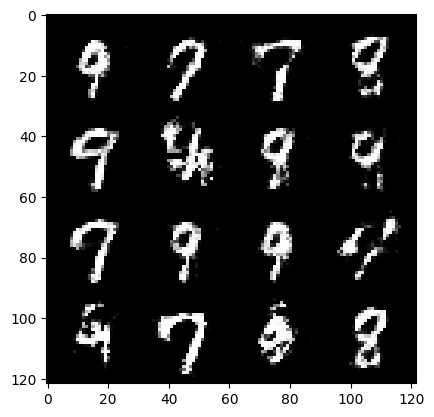

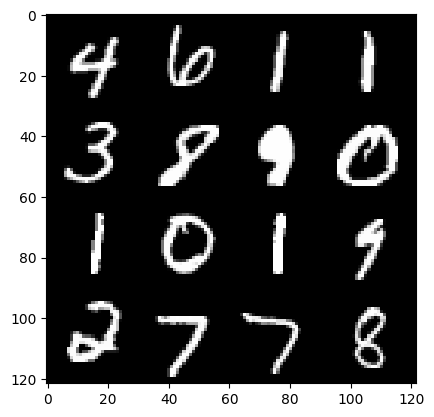

 71%|███████   | 333/469 [00:03<00:01, 80.51it/s]

Epoch 123, Step 58000: Gen Loss 2.4183959190845523, Disc Loss 0.2159266634657983


 93%|█████████▎| 437/469 [00:04<00:00, 98.89it/s] 

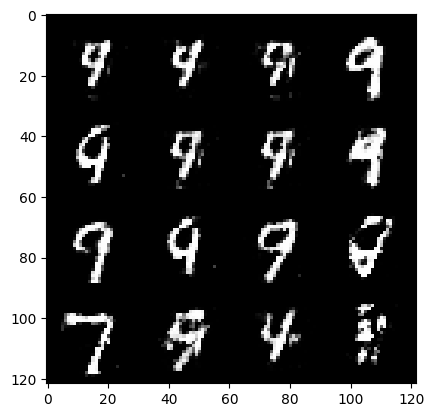

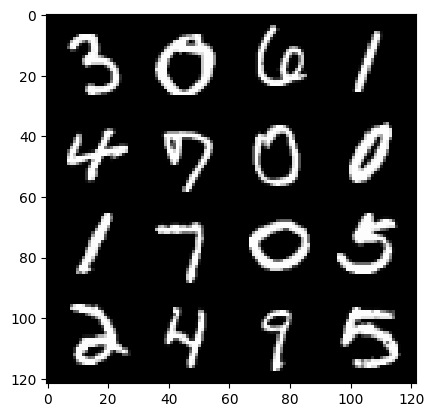

 97%|█████████▋| 457/469 [00:04<00:00, 81.97it/s]

Epoch 127, Step 60000: Gen Loss 2.3434403949379856, Disc Loss 0.22285926159471228


 18%|█▊        | 86/469 [00:00<00:03, 100.91it/s]

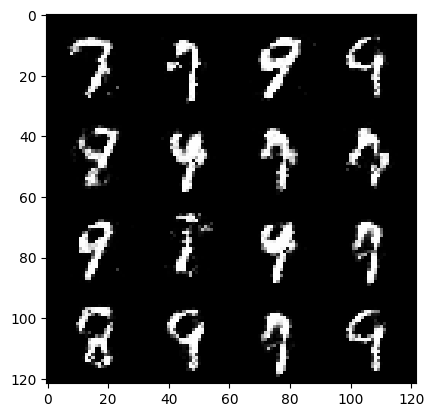

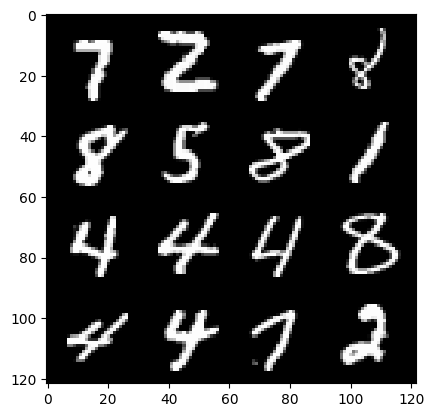

 23%|██▎       | 107/469 [00:01<00:04, 82.20it/s]

Epoch 132, Step 62000: Gen Loss 2.3982465329766223, Disc Loss 0.21261965350434153


 45%|████▍     | 209/469 [00:01<00:02, 106.89it/s]

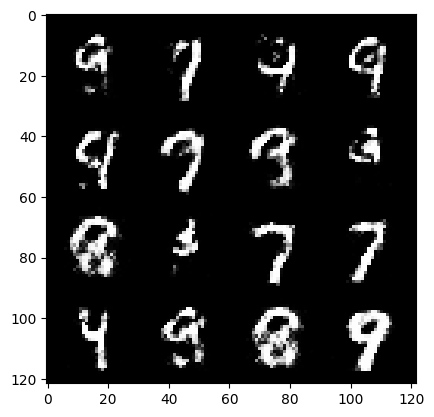

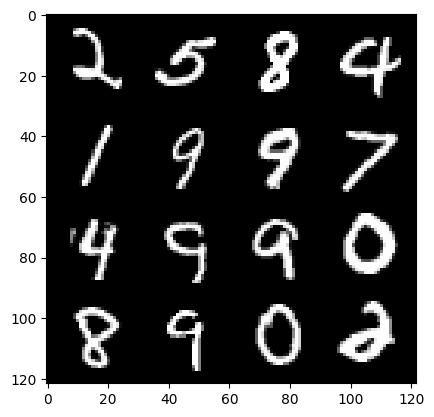

 49%|████▉     | 231/469 [00:02<00:02, 86.49it/s] 

Epoch 136, Step 64000: Gen Loss 2.4334383128881476, Disc Loss 0.2077177682816986


 70%|███████   | 330/469 [00:03<00:01, 109.00it/s]

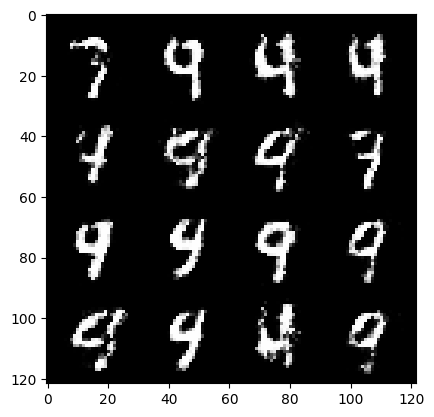

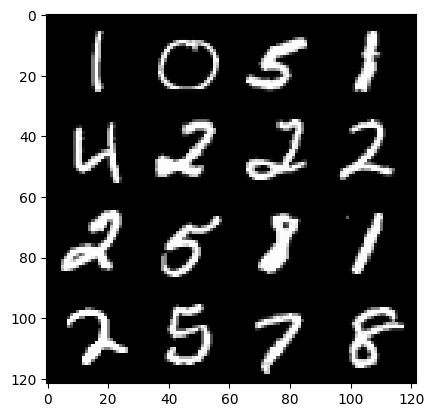

 75%|███████▌  | 352/469 [00:03<00:01, 91.02it/s] 

Epoch 140, Step 66000: Gen Loss 2.357948087871074, Disc Loss 0.2182708823606371


 99%|█████████▊| 463/469 [00:04<00:00, 106.83it/s]

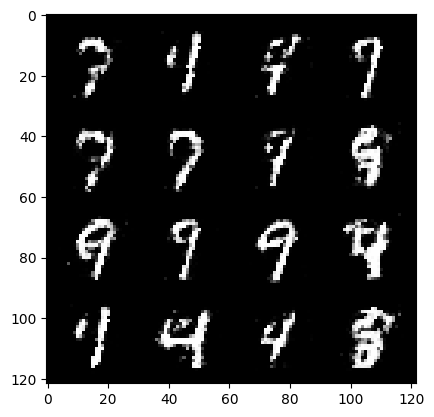

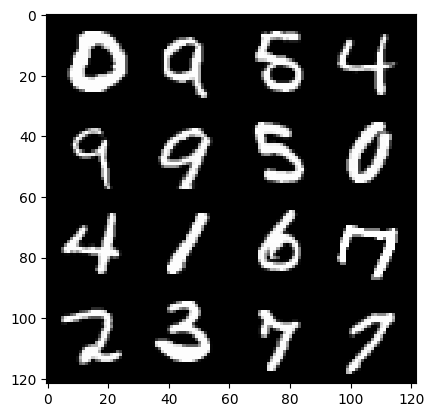

100%|██████████| 469/469 [00:04<00:00, 104.69it/s]


Epoch 144, Step 68000: Gen Loss 2.2546854017376905, Disc Loss 0.23315060053020703


 23%|██▎       | 110/469 [00:01<00:03, 107.23it/s]

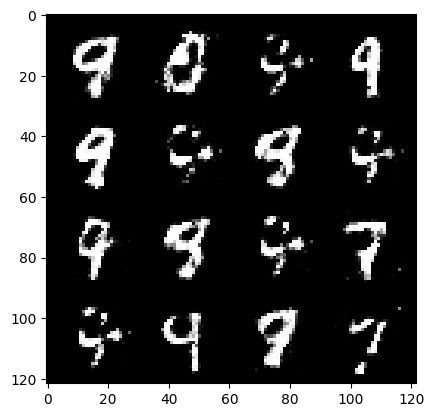

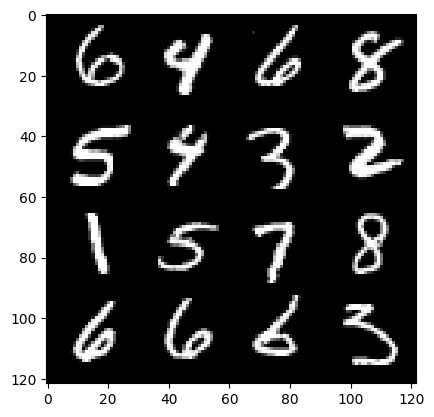

 28%|██▊       | 131/469 [00:01<00:03, 86.44it/s] 

Epoch 149, Step 70000: Gen Loss 2.2683553543090853, Disc Loss 0.23527968649193678


 50%|█████     | 236/469 [00:02<00:02, 106.57it/s]

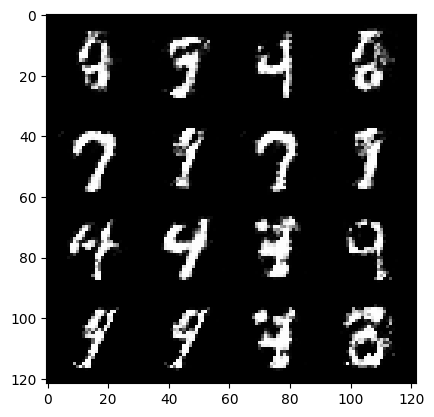

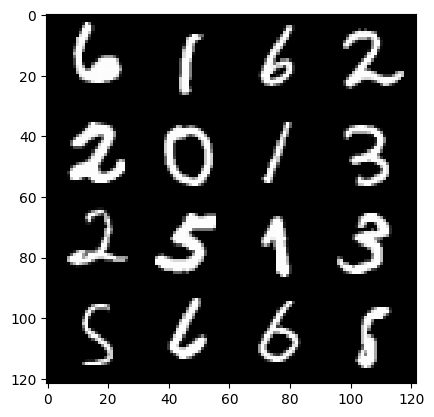

 55%|█████▍    | 257/469 [00:02<00:02, 86.46it/s] 

Epoch 153, Step 72000: Gen Loss 2.26838992470503, Disc Loss 0.23208452857658263


 78%|███████▊  | 365/469 [00:03<00:00, 108.52it/s]

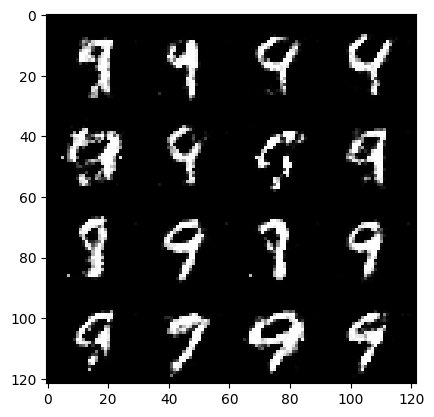

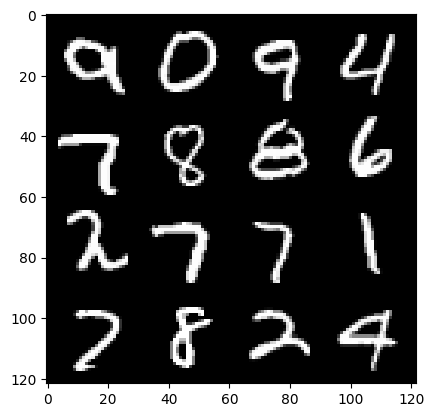

 83%|████████▎ | 387/469 [00:03<00:00, 86.50it/s] 

Epoch 157, Step 74000: Gen Loss 2.229194697022437, Disc Loss 0.24283096224814651


  5%|▍         | 22/469 [00:00<00:04, 108.72it/s]

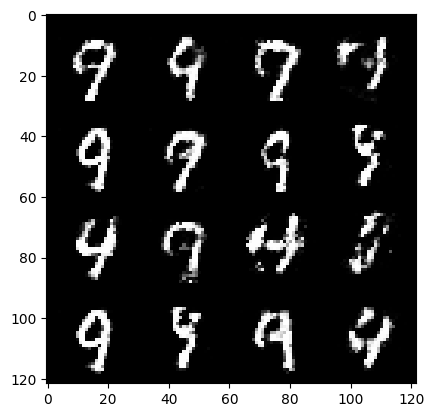

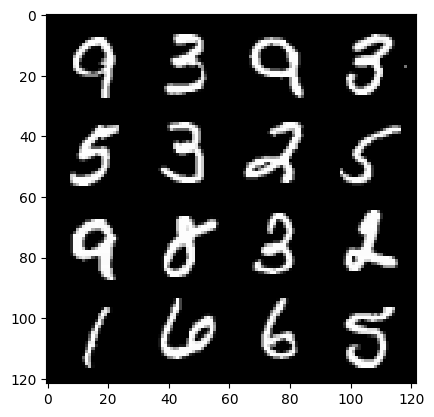

  7%|▋         | 33/469 [00:00<00:05, 74.37it/s] 

Epoch 162, Step 76000: Gen Loss 2.318424357771871, Disc Loss 0.23244444734975703


 30%|███       | 143/469 [00:01<00:02, 109.48it/s]

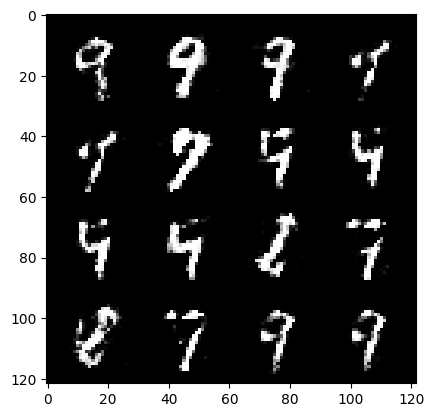

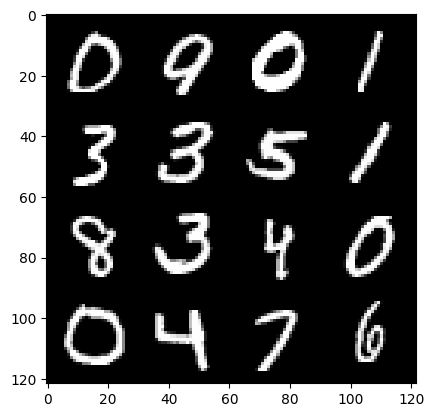

 35%|███▌      | 165/469 [00:01<00:03, 88.21it/s] 

Epoch 166, Step 78000: Gen Loss 2.333476627707485, Disc Loss 0.21831272978335559


 56%|█████▋    | 264/469 [00:02<00:01, 106.55it/s]

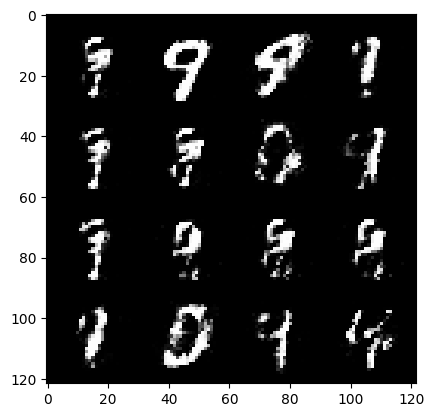

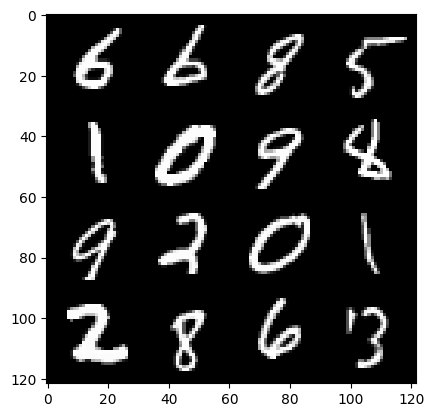

 61%|██████    | 285/469 [00:02<00:02, 86.41it/s] 

Epoch 170, Step 80000: Gen Loss 2.2625859421491623, Disc Loss 0.23070353964343665


 82%|████████▏ | 385/469 [00:03<00:00, 107.22it/s]

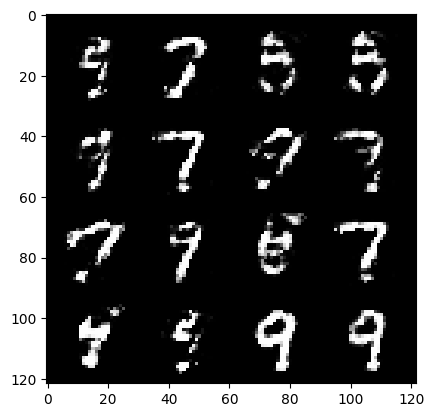

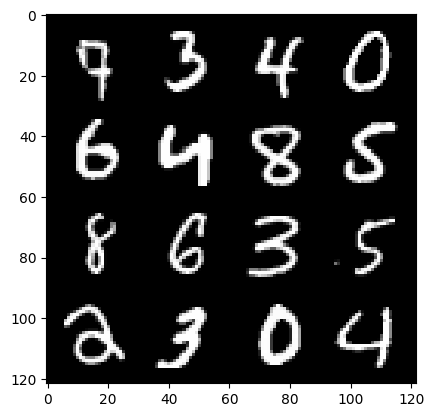

 87%|████████▋ | 407/469 [00:03<00:00, 88.77it/s] 

Epoch 174, Step 82000: Gen Loss 2.239334507048132, Disc Loss 0.2346202031075952


  9%|▉         | 44/469 [00:00<00:03, 107.75it/s]

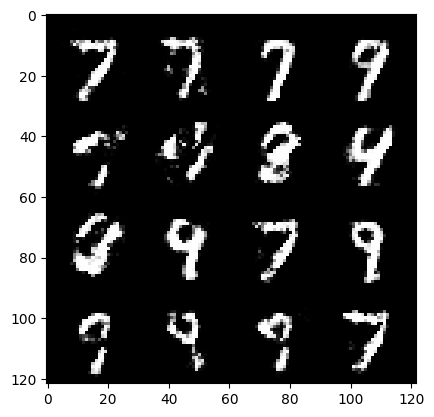

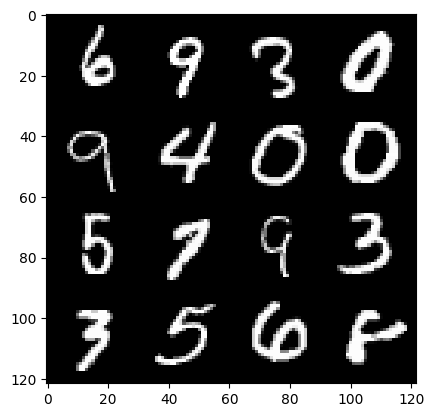

 14%|█▍        | 66/469 [00:00<00:04, 85.83it/s] 

Epoch 179, Step 84000: Gen Loss 2.0569028813242918, Disc Loss 0.2685437272414565


 36%|███▌      | 168/469 [00:01<00:03, 94.63it/s] 

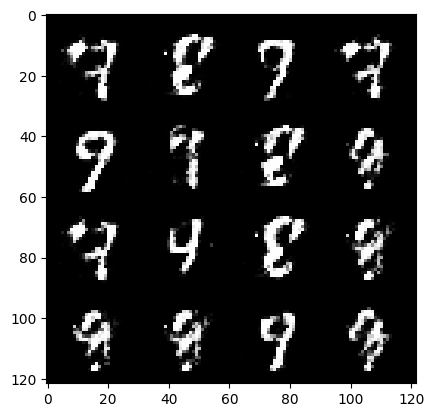

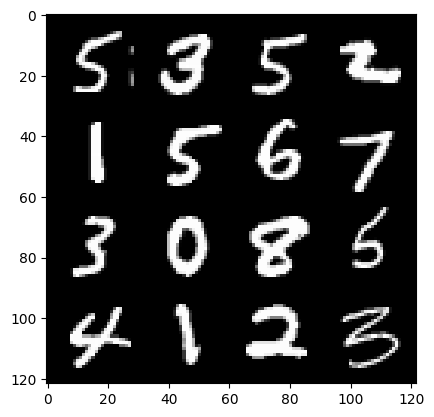

 40%|████      | 188/469 [00:02<00:03, 77.83it/s]

Epoch 183, Step 86000: Gen Loss 2.1132499106526392, Disc Loss 0.2617530232071877


 61%|██████▏   | 288/469 [00:03<00:01, 91.19it/s]

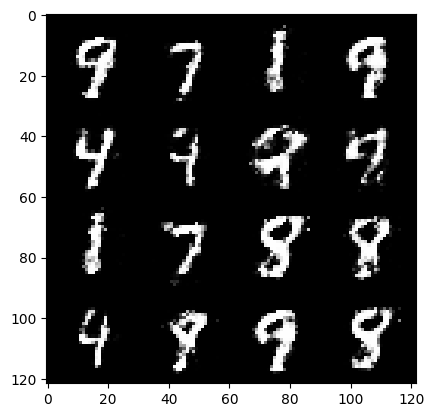

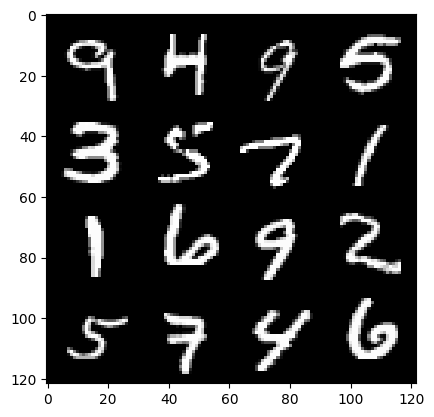

 65%|██████▌   | 307/469 [00:03<00:02, 73.61it/s]

Epoch 187, Step 88000: Gen Loss 2.09754839581251, Disc Loss 0.26646632882207655


 89%|████████▊ | 416/469 [00:04<00:00, 88.52it/s]

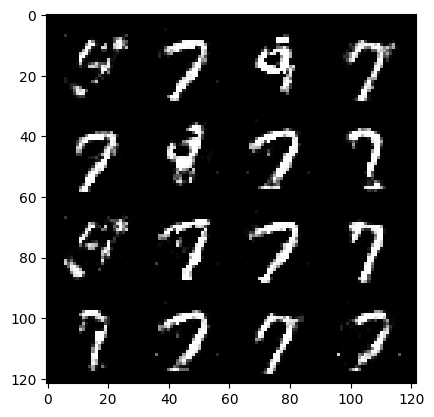

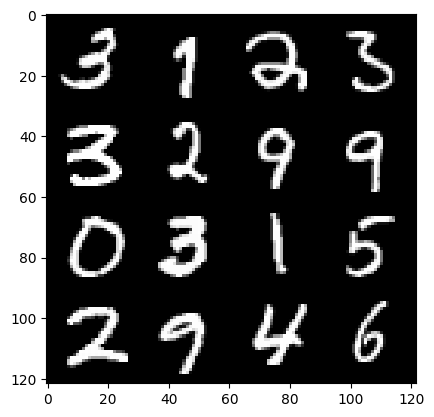

 93%|█████████▎| 434/469 [00:05<00:00, 71.63it/s]

Epoch 191, Step 90000: Gen Loss 2.0292886301279096, Disc Loss 0.2750871225893494


 15%|█▌        | 72/469 [00:00<00:04, 87.98it/s]

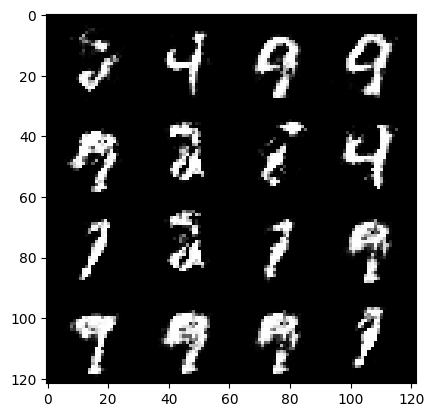

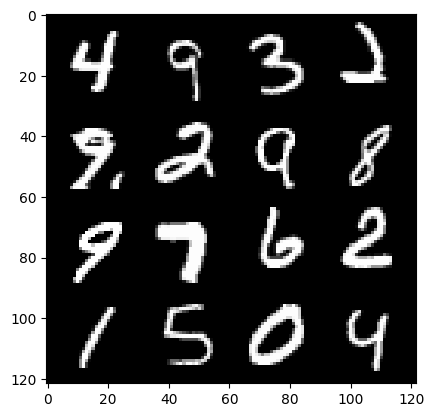

 19%|█▉        | 90/469 [00:01<00:05, 71.17it/s]

Epoch 196, Step 92000: Gen Loss 1.9514632697105396, Disc Loss 0.2915752153098584


 42%|████▏     | 198/469 [00:02<00:03, 88.91it/s]

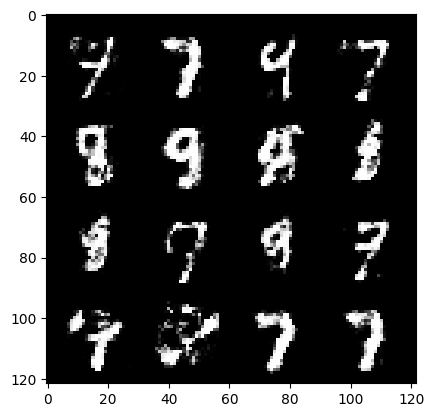

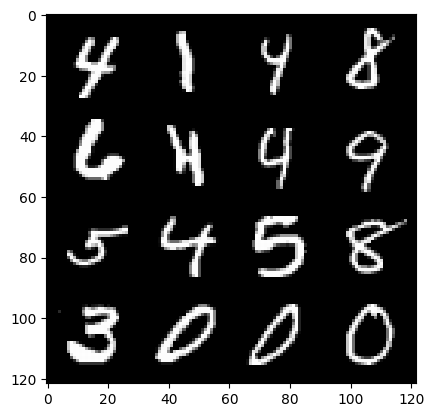

 46%|████▌     | 216/469 [00:02<00:03, 71.29it/s]

Epoch 200, Step 94000: Gen Loss 2.0516626667380344, Disc Loss 0.2724319055676461


 68%|██████▊   | 317/469 [00:03<00:01, 87.96it/s]

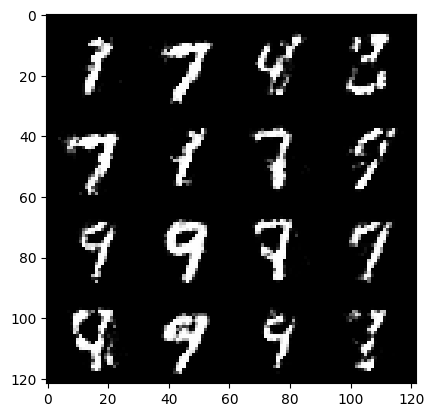

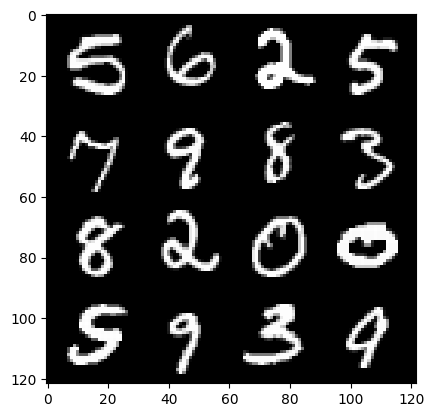

 71%|███████   | 334/469 [00:03<00:01, 69.84it/s]

Epoch 204, Step 96000: Gen Loss 2.0011416295170776, Disc Loss 0.2749133093208077


 95%|█████████▌| 446/469 [00:05<00:00, 83.65it/s]

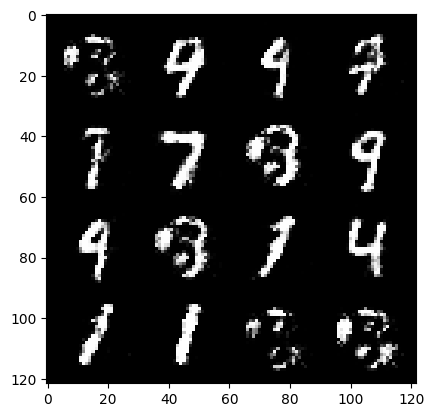

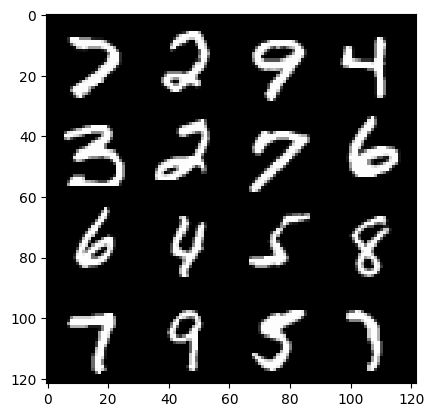

 99%|█████████▊| 463/469 [00:05<00:00, 66.35it/s]

Epoch 208, Step 98000: Gen Loss 1.9159661634564369, Disc Loss 0.29368687327951176


 21%|██▏       | 100/469 [00:01<00:03, 97.90it/s]

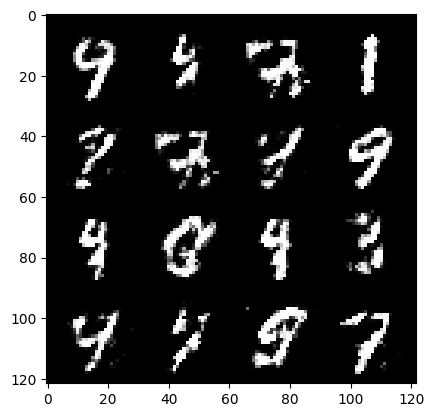

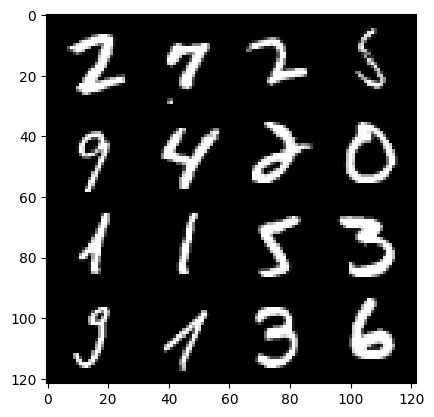

 26%|██▌       | 120/469 [00:01<00:04, 78.83it/s]

Epoch 213, Step 100000: Gen Loss 1.8990364397764181, Disc Loss 0.2976820487231016


 48%|████▊     | 227/469 [00:02<00:02, 92.84it/s]

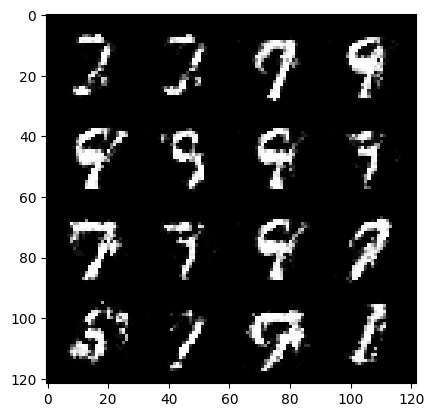

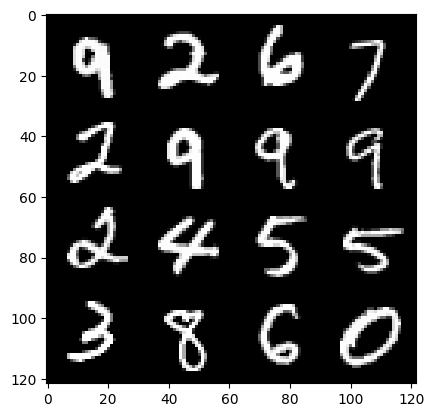

 51%|█████     | 237/469 [00:03<00:04, 57.68it/s]

Epoch 217, Step 102000: Gen Loss 1.8086523862481108, Disc Loss 0.3303000894188878


 74%|███████▍  | 347/469 [00:04<00:01, 87.80it/s]

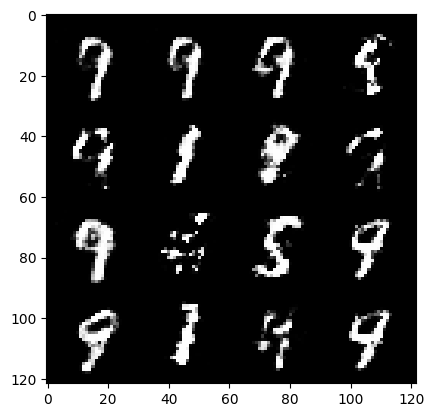

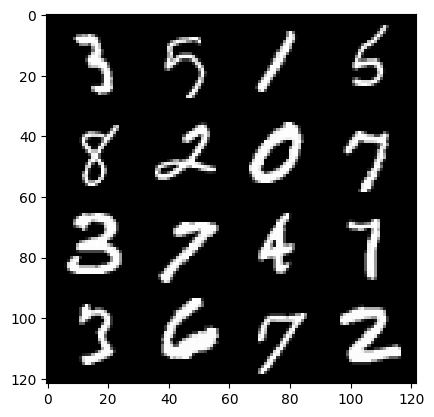

 78%|███████▊  | 364/469 [00:04<00:01, 70.05it/s]

Epoch 221, Step 104000: Gen Loss 1.9165050041675549, Disc Loss 0.29017833844572305


  0%|          | 0/469 [00:00<?, ?it/s]

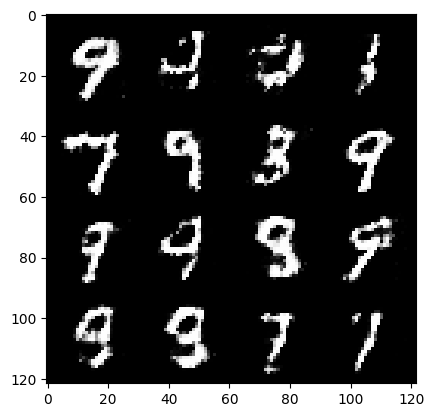

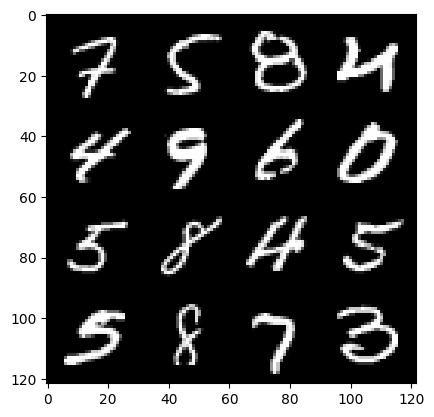

  3%|▎         | 16/469 [00:00<00:07, 60.10it/s]

Epoch 226, Step 106000: Gen Loss 1.7772072920203243, Disc Loss 0.32307438592612814


 27%|██▋       | 127/469 [00:01<00:03, 89.51it/s]

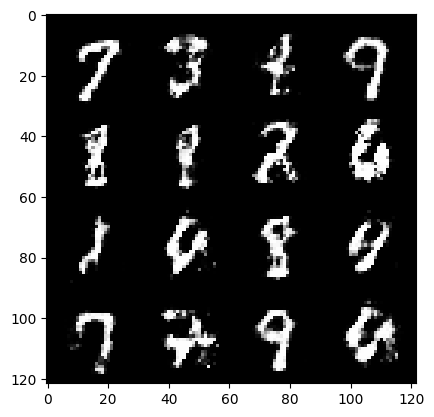

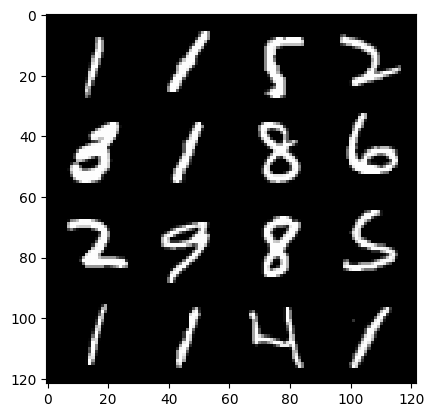

 31%|███       | 144/469 [00:01<00:04, 70.53it/s]

Epoch 230, Step 108000: Gen Loss 1.8070070937275888, Disc Loss 0.3210159160047766


 52%|█████▏    | 245/469 [00:02<00:02, 91.50it/s]

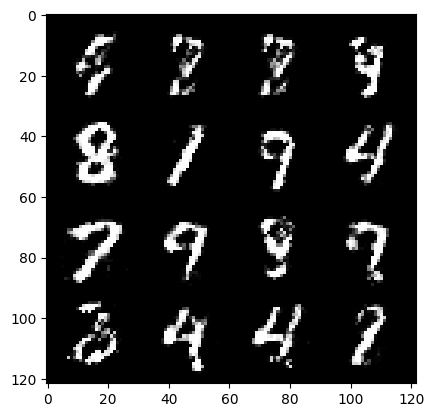

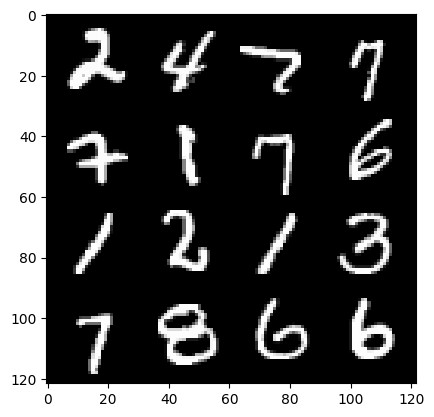

 56%|█████▋    | 264/469 [00:03<00:02, 75.07it/s]

Epoch 234, Step 110000: Gen Loss 1.7487738335132579, Disc Loss 0.3299750665053731


 79%|███████▉  | 370/469 [00:04<00:01, 80.44it/s]

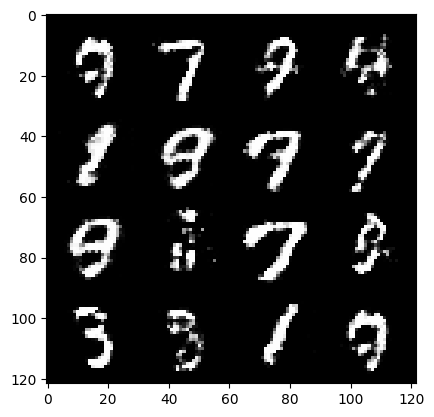

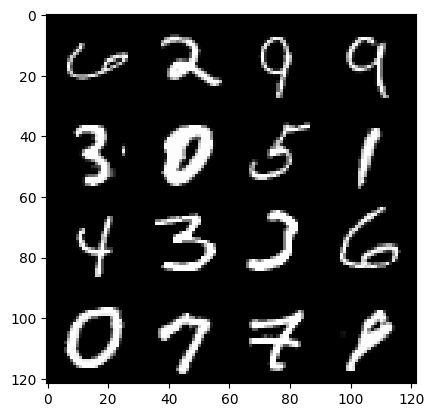

 83%|████████▎ | 388/469 [00:04<00:01, 67.33it/s]

Epoch 238, Step 112000: Gen Loss 1.7304112287759794, Disc Loss 0.33541751042008405


  7%|▋         | 32/469 [00:00<00:04, 102.41it/s]

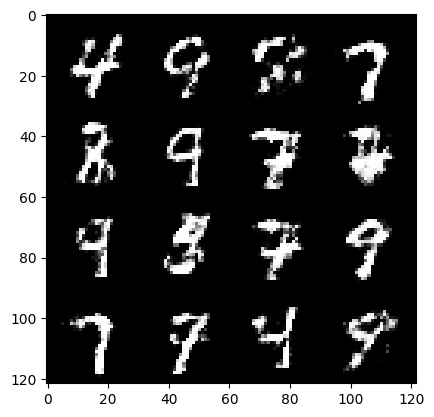

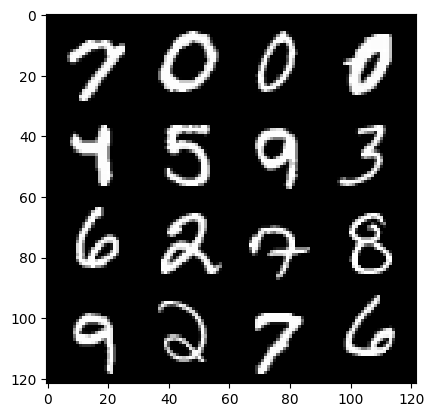

 12%|█▏        | 54/469 [00:00<00:05, 81.32it/s] 

Epoch 243, Step 114000: Gen Loss 1.6217858219742798, Disc Loss 0.3615264236852529


 33%|███▎      | 157/469 [00:01<00:03, 96.49it/s]

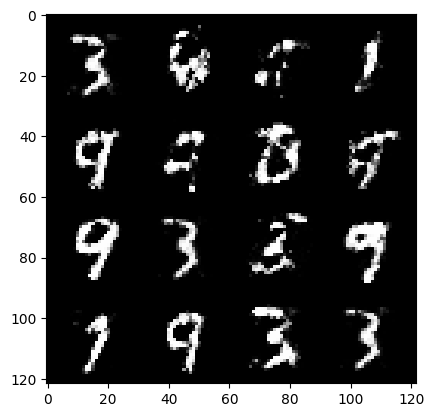

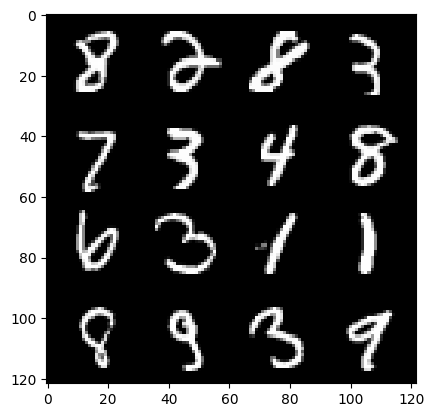

 36%|███▌      | 167/469 [00:01<00:04, 73.02it/s]

Epoch 247, Step 116000: Gen Loss 1.5889280042648315, Disc Loss 0.3702868054509166


 59%|█████▉    | 277/469 [00:03<00:02, 91.88it/s]

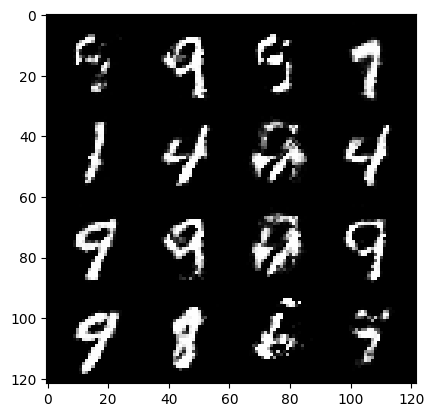

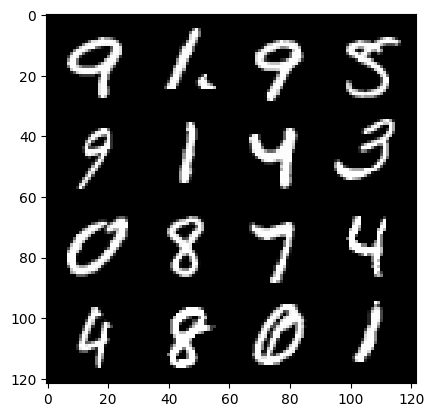

 63%|██████▎   | 295/469 [00:03<00:02, 73.26it/s]

Epoch 251, Step 118000: Gen Loss 1.5784407354593275, Disc Loss 0.37600503717362876


 86%|████████▌ | 403/469 [00:04<00:00, 90.44it/s]

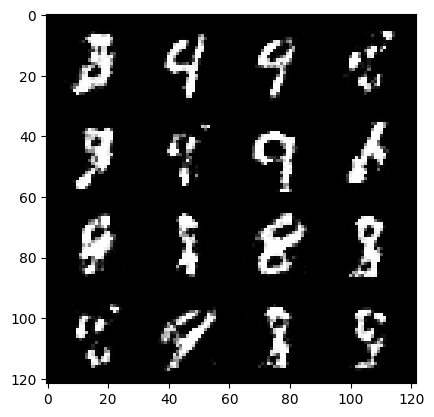

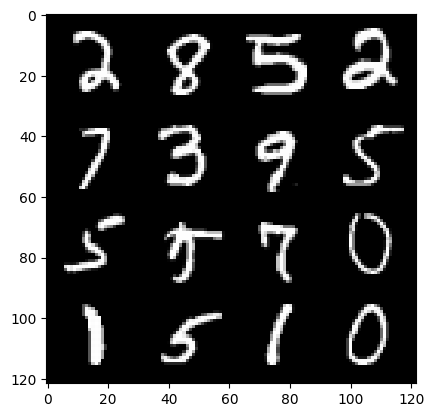

 90%|████████▉ | 422/469 [00:04<00:00, 73.34it/s]

Epoch 255, Step 120000: Gen Loss 1.6173397573828685, Disc Loss 0.35820907960832066


 13%|█▎        | 59/469 [00:00<00:04, 89.45it/s]

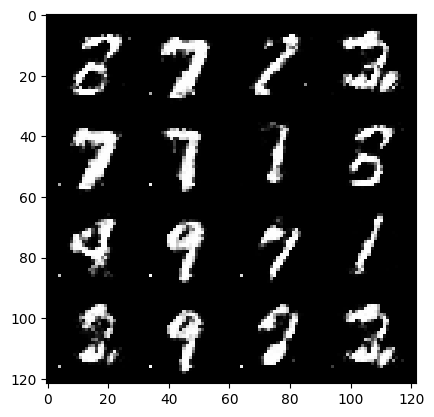

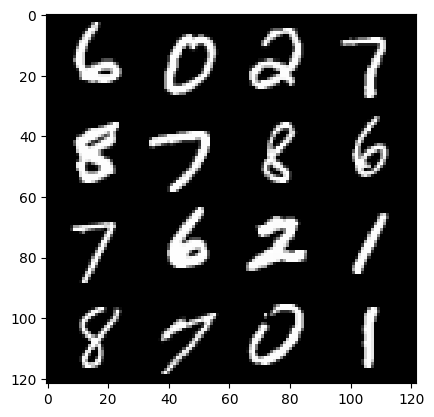

 16%|█▌        | 76/469 [00:00<00:05, 69.72it/s]

Epoch 260, Step 122000: Gen Loss 1.5057594209313405, Disc Loss 0.3929504290819176


 38%|███▊      | 176/469 [00:01<00:03, 92.10it/s]

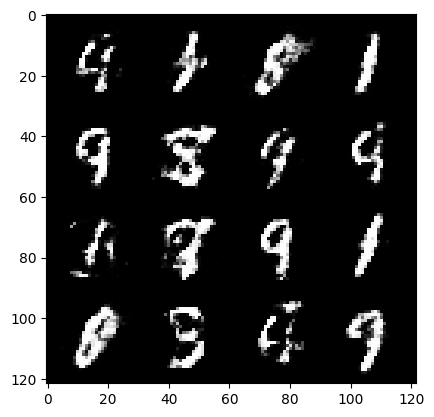

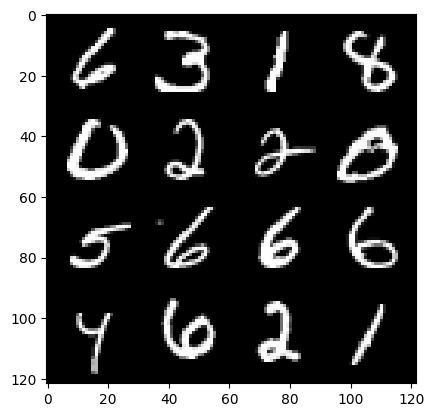

 42%|████▏     | 195/469 [00:02<00:03, 73.28it/s]

Epoch 264, Step 124000: Gen Loss 1.5527179550528545, Disc Loss 0.3733485331684351


 65%|██████▍   | 304/469 [00:03<00:01, 87.26it/s]

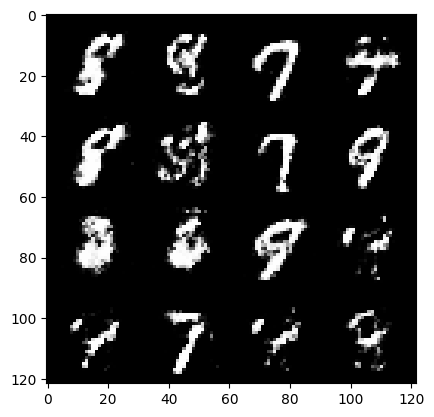

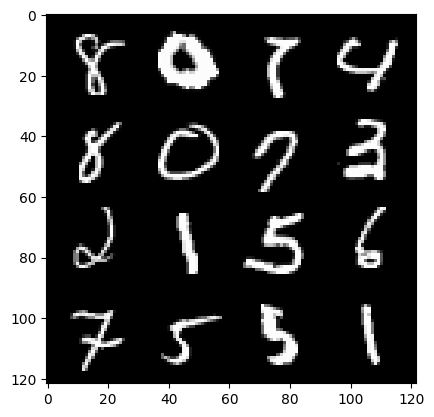

 68%|██████▊   | 321/469 [00:03<00:02, 70.12it/s]

Epoch 268, Step 126000: Gen Loss 1.4943531340360665, Disc Loss 0.3972161046117544


 91%|█████████▏| 428/469 [00:04<00:00, 103.35it/s]

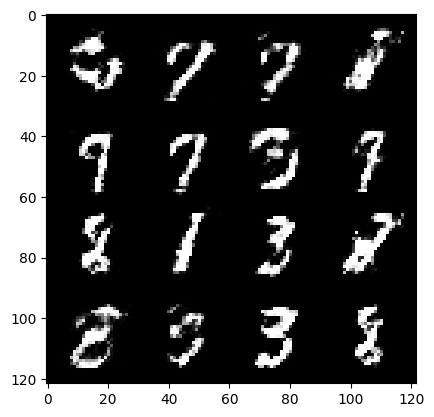

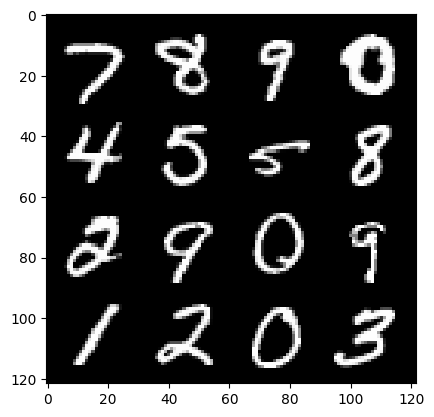

 96%|█████████▌| 449/469 [00:04<00:00, 82.55it/s] 

Epoch 272, Step 128000: Gen Loss 1.52750196939707, Disc Loss 0.38479799604415865


 17%|█▋        | 79/469 [00:00<00:04, 92.05it/s]

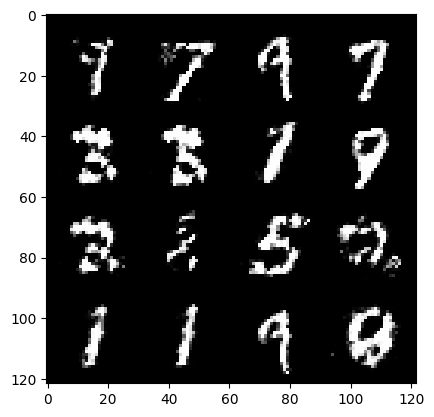

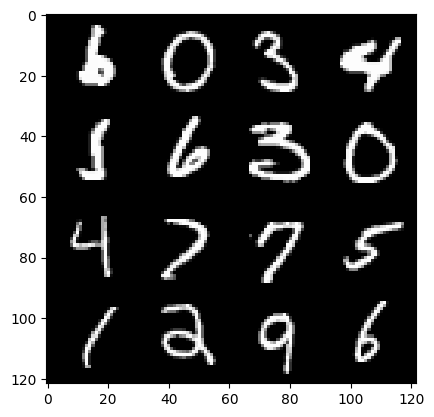

 21%|██        | 97/469 [00:01<00:05, 67.08it/s]

Epoch 277, Step 130000: Gen Loss 1.5874808838367493, Disc Loss 0.36776808796823035


 45%|████▍     | 211/469 [00:02<00:03, 85.84it/s]

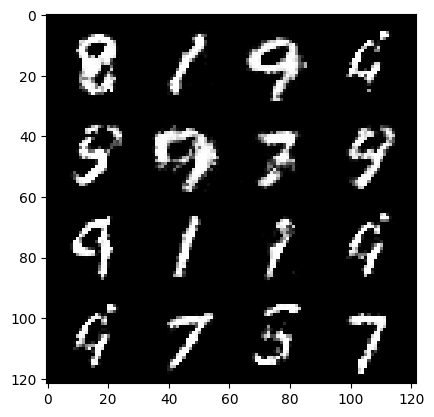

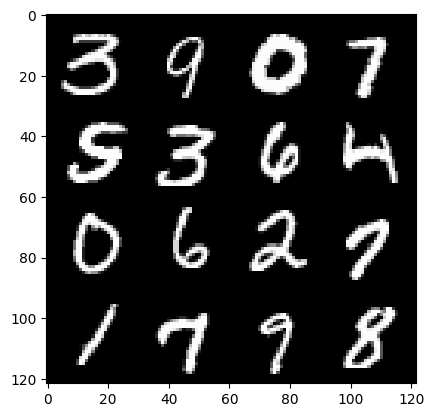

 47%|████▋     | 220/469 [00:02<00:03, 64.02it/s]

Epoch 281, Step 132000: Gen Loss 1.5558658136129422, Disc Loss 0.37975261877477196


 70%|███████   | 329/469 [00:03<00:01, 88.54it/s]

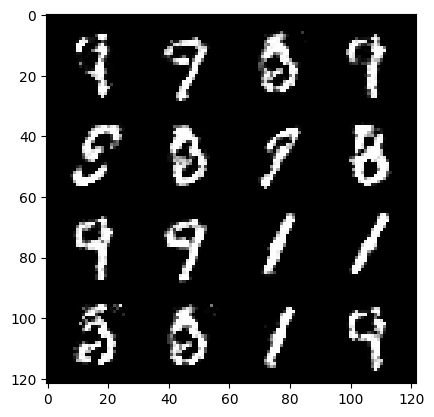

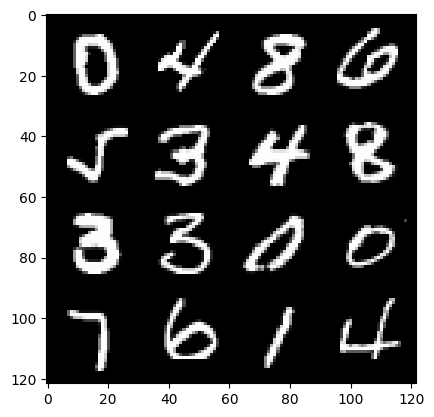

 74%|███████▍  | 346/469 [00:03<00:01, 69.70it/s]

Epoch 285, Step 134000: Gen Loss 1.515294558942317, Disc Loss 0.38169203425943843


 96%|█████████▌| 451/469 [00:04<00:00, 83.13it/s] 

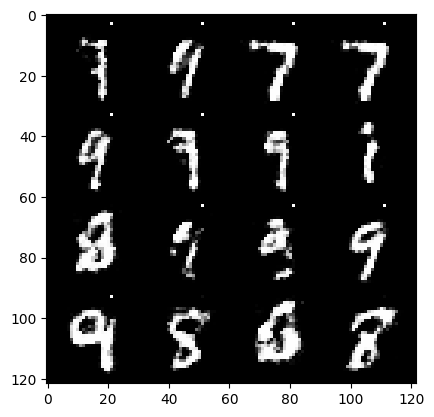

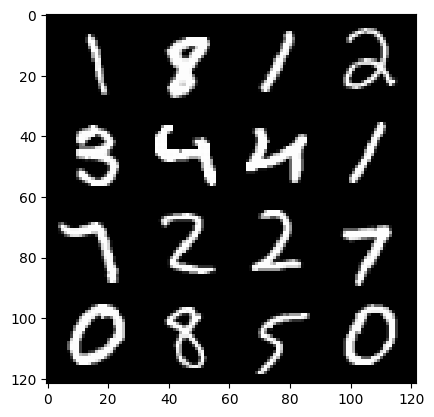

100%|██████████| 469/469 [00:05<00:00, 90.42it/s]


Epoch 289, Step 136000: Gen Loss 1.4249115928709526, Disc Loss 0.41396960765123325


 23%|██▎       | 110/469 [00:01<00:03, 103.73it/s]

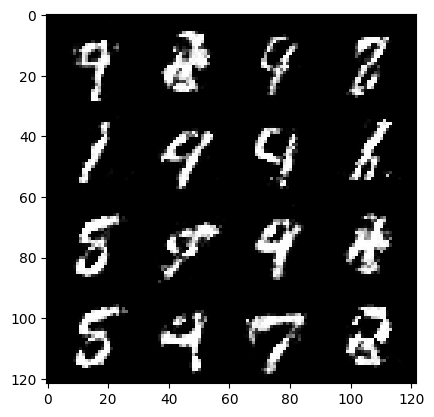

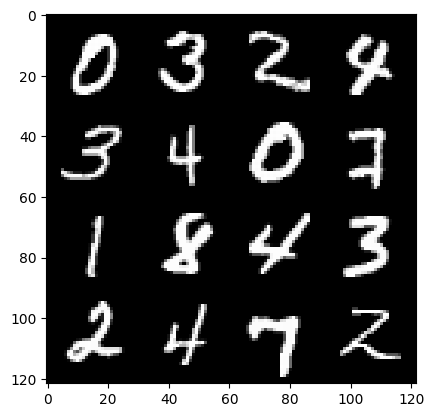

 28%|██▊       | 131/469 [00:01<00:04, 81.84it/s] 

Epoch 294, Step 138000: Gen Loss 1.4940615707039846, Disc Loss 0.3962506351917982


 49%|████▉     | 232/469 [00:02<00:02, 91.75it/s]

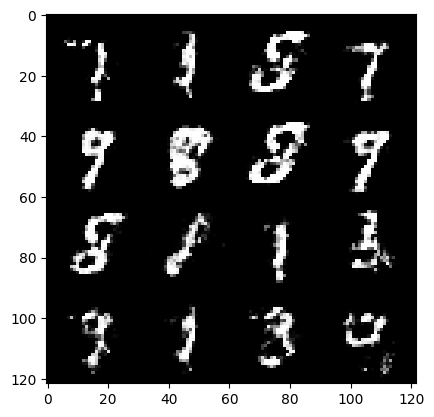

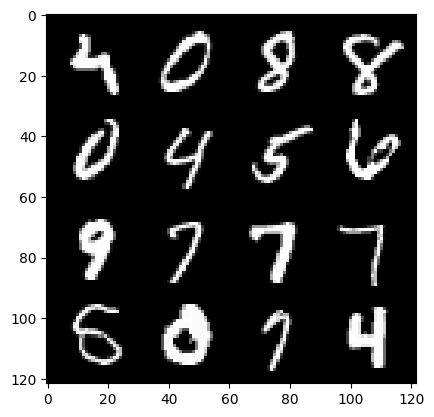

 53%|█████▎    | 250/469 [00:02<00:03, 70.76it/s]

Epoch 298, Step 140000: Gen Loss 1.5629280874729168, Disc Loss 0.3851528554260734


100%|██████████| 469/469 [00:04<00:00, 96.67it/s] 


In [21]:
for epoch in range(epochs):
    for real, _ in tqdm(dataloader):
        ### discriminator
        disc_opt.zero_grad()

        cur_bs = len(real)
        real = real.view(cur_bs, -1).to(device) # 128 x 784
        real = real.to(device)

        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)

        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        ### generator
        gen_opt.zero_grad()
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        ###visualization
        mean_disc_loss += disc_loss.item() / info_step
        mean_gen_loss += gen_loss.item() / info_step

        if cur_step % info_step == 0 and cur_step > 0:
            fake_noise = gen_noise(cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake)
            show(real)
            print(f"Epoch {epoch}, Step {cur_step}: Gen Loss {mean_gen_loss}, Disc Loss {mean_disc_loss}")
            mean_gen_loss = 0
            mean_disc_loss = 0
        cur_step += 1